In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from scipy import special, integrate
import os
import sys

sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfuncs
import tools

### covariance of the 3D 2pcf

Eq. 12 in Heitmann et al. (2021): https://ui.adsabs.harvard.edu/abs/2021ApJS..252...19H/abstract *

$$
C_\xi(r,r')=\int\frac{k^2\mathrm{d}k}{2\pi^2}j_0(kr)\,j_0(kr')\,\sigma^2_P(k) ~,
$$

where $\sigma_P$ is the shot noise component:
$$
\sigma^2_P = \frac{2}{V}\left(P(k)+\frac{1}{\bar n}\right)^2 ~,
$$
$P(k)$ is the matter power spectrum (?), $V$ is the simulation volume, and $\bar n$ is the mean tracer number density.

Then the standard deviation of the 2pcf is just
$$
\sigma_\xi(r) = \sqrt{C_\xi(r,r')}
$$

\* also cites Cohn (2006) and Smith et al. (2008)

In [3]:
# initialize simulation
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)

# define conversions
def theta_to_r_comov_(theta):
    return tools.theta_to_r_comov(theta, redshift)
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, redshift)

# comoving distance to the box center
r_dist = tools.redshift_to_comov(sim.redshift)

def ell_to_k(ell):
    return (ell + 0.5) / r_dist.value
def k_to_ell(k):
    return (k * r_dist.value) - 0.5

In [4]:
# construct spectroscopic sample
sigma_z = 0.01
# spectroscopic sample
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2

 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


#### inputs

In [5]:
# ell, k, and r
npts = 100

ell = np.logspace(0, 6, npts)
k = ell_to_k(ell)

r_edges = np.logspace(np.log10(0.1), np.log10(100.), npts+1)
r = 0.5 * (r_edges[1:] + r_edges[:-1])

#### shot noise component $\sigma_P$

In [6]:
# power spectrum from colossus
cosmo = cosmology.setCosmology('planck15')
P = cosmo.matterPowerSpectrum(k, redshift)

In [7]:
V = sim.boxsize ** 3
nbar = len(gal_pos_spec) / V

In [8]:
sigma_P_sq = 2 / V.value * (P + 1 / nbar.value)**2

Text(0.5, 1.0, 'shot noise $\\sigma_P^2$ in 2pcf')

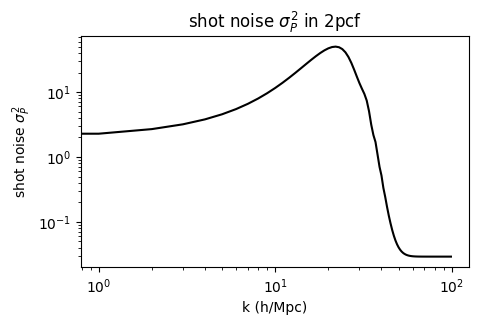

In [9]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(sigma_P_sq, 'k-')
ax.loglog()
ax.set_xlabel('k (h/Mpc)')
ax.set_ylabel('shot noise $\sigma_P^2$')
ax.set_title(r'shot noise $\sigma_P^2$ in 2pcf')

### integrate

In [10]:
def sigma_P_sq(k):
    P = cosmo.matterPowerSpectrum(k, redshift)
    return 2 / V.value * (P + 1 / nbar.value)**2

In [11]:
# only focus on the diagonal terms in the covariance, for now
def var(r):
    # multiplicative constant
    const = 1 / (2 * np.pi**2)

    # function of k that we want to integrate
    def integrand(k):
        return k**2 * special.jv(0, k * r)**2 * sigma_P_sq(k)

    # construct our array, and integrate using trapezoid rule
    k_func_arr = np.array([integrand(k_) for k_ in k])
    trapz = integrate.trapz(k_func_arr, x=k)

    return const*trapz

In [12]:
pred_var = var(r)

Text(0.5, 1.0, 'Predicted 2pcf uncertainty $\\sigma_\\xi(r)$')

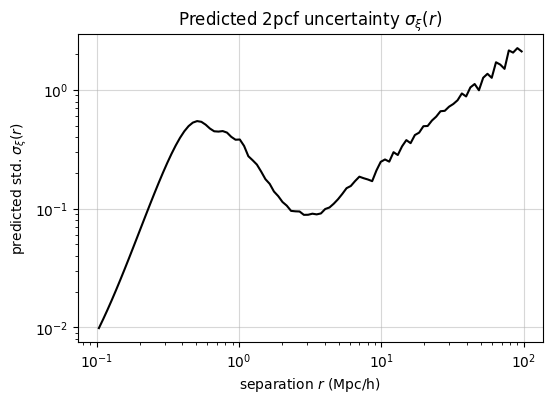

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(r, np.sqrt(pred_var), 'k-')
ax.loglog()
ax.grid(alpha=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'predicted std. $\sigma_\xi(r)$')
ax.set_title(r'Predicted 2pcf uncertainty $\sigma_\xi(r)$')

### covariance of the 2D 2pcf

$$
C_w(\theta_a,\theta_b)=\frac{2(2\pi)^3}{A_\Omega}\int_0^\infty k\,\mathrm{d}k\,[P(k)]^2\,J_0(k\theta_a)\,J_0(k\theta_b)
$$

In [27]:
# only focus on the diagonal terms in the covariance, for now
def var(theta, k, sim):
    
    theta = theta.to(u.rad) if isinstance(theta, u.Quantity) else (theta * u.deg).to(u.rad)
    
    # area
    A = (tools.r_comov_to_theta(sim.boxsize, sim.redshift) * u.deg).to(u.rad)**2
    
    # multiplicative constant
    const = 2 * (2 * np.pi)**3 / sim.boxsize.value**2

    # function of k that we want to integrate
    def integrand(k):
        return k * special.jv(0, k * theta.value)**2 * cosmo.matterPowerSpectrum(k, sim.redshift)**2

    # construct our array, and integrate using trapezoid rule
    k_func_arr = np.array([integrand(k_) for k_ in k])
    trapz = integrate.trapz(k_func_arr, x=k)

    return const*trapz

In [28]:
# ell, k, and theta
npts = 100

ell = np.logspace(0, 6, npts)
k = ell_to_k(ell)
theta = np.logspace(np.log10(0.0001), np.log10(10.), npts) * u.deg

In [29]:
pred_var = var(theta, k, sim)

Text(0.5, 1.0, 'Predicted 2pcf uncertainty $\\sigma_w(\\theta)$')

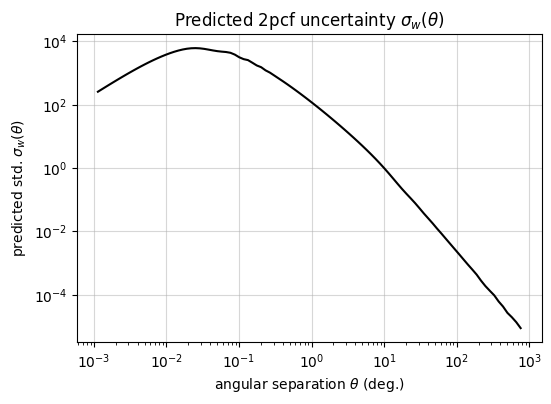

In [30]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(k, np.sqrt(pred_var), 'k-')
ax.loglog()
ax.grid(alpha=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg.)')
ax.set_ylabel(r'predicted std. $\sigma_w(\theta)$')
ax.set_title(r'Predicted 2pcf uncertainty $\sigma_w(\theta)$')